In [1]:
import librosa, numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.load(librosa.ex('trumpet'), duration=2.0)



In [2]:
def generate_sinusoid(duration,sample_rate = 48000):
    """Generate a sinusoid for the specified duration at 48kHz sample rate"""
      # Hz
    frequency = 440  # Hz (A4 note)
    
    # Generate time array
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    
    # Generate sinusoid with some modulation to make it more interesting
    waveform = np.sin(2 * np.pi * frequency * t) * np.exp(-t/20)  # Decaying sinusoid
    
    # Normalize to [-1, 1]
    if len(waveform) > 0:
        waveform = waveform / np.max(np.abs(waveform))
    
    return t, waveform

sample_rate = 48000  # Hz
time_data, waveform_data = generate_sinusoid(18.0, sample_rate=sample_rate)

Slice 1: Time range 3.00 to 6.00 seconds, Waveform length: 144001 samples


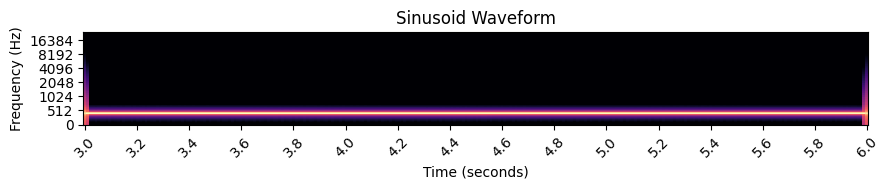

In [ ]:
title= 'Sinusoid Waveform'



slice_id = 1

sliceDuration = 3  # seconds
sample_rate = 48000

# Calculate slice boundaries
start_sample = slice_id * sliceDuration * sample_rate
end_sample = min((slice_id + 1) * sliceDuration * sample_rate, len(time_data))

# Extract slice data
slice_time = time_data[start_sample:end_sample+1]
slice_waveform = waveform_data[start_sample:end_sample+1]

# Adjust time to start from 0 for the slice
# slice_time = slice_time - slice_time[0]

print(f"Slice {slice_id}: Time range {slice_time[0]:.2f} to {slice_time[-1]:.2f} seconds, "
      f"Waveform length: {len(slice_waveform)} samples")




fig, ax = plt.subplots(figsize=(9, 2))

S = librosa.feature.melspectrogram(y=slice_waveform, sr=sample_rate, n_mels=128, fmax=24000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax, cmap='magma')
if (title):
    ax.set_title(title)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency (Hz)')
# plt.colorbar(img, ax=ax, format='%+2.0f dB')

# Set x labels and ticks to match the time data passed
zerobased_time = slice_time - slice_time[0]  # Adjust time to start from 0
XAX_FACTOR = 5
ax.set_xticks(zerobased_time[::int(len(zerobased_time)/sliceDuration/XAX_FACTOR)])  # Show 10 ticks
ax.set_xticklabels([f"{t:.1f}" for t in slice_time[::int(len(slice_time)/sliceDuration/XAX_FACTOR)]], rotation=45)

plt.tight_layout()

plt.show()

# Test display emotions per slice

In [4]:
import emotions
import librosa, os
import matplotlib.pyplot as plt
import io
import base64
import numpy as np

emotionClassifier = emotions.EmotionClassifier("../classifier/best_model_1_acc_53.14.h5")

# load file webapp_proto\recordings\recording_20250624_121056.wav
CLASSIFIER_SR = 22050  # Sample rate for the classifier
HIGH_SAMPLE_RATE = 48000  # High sample rate for the original audio

FILENAME = 'recordings/recording_20250624_115335.wav'
assert FILENAME.endswith('.wav'), "File must be a .wav file"
assert os.path.exists(FILENAME), f"File {FILENAME} does not exist"

waveform_data, sr = librosa.load(FILENAME, sr=HIGH_SAMPLE_RATE)
lores_waveform_data, sr = librosa.load(FILENAME, sr=CLASSIFIER_SR)


mels, segments, startstop = emotions.split_song(lores_waveform_data,
                                    sampling_rate=CLASSIFIER_SR,
                                    segment_duration_s=3,
                                    overlap=0)

pred_segment_emotions = []
for mel_rgb_batch in mels:
    # Predict emotions using the classifier
    pred_emotion_label, pred_probabilities = emotionClassifier.predict_segment(mel_rgb_batch)
    # print('shape of pred_emotion_label:', np.shape(pred_emotion_label))
    # print('shape of pred_probabilities:', np.shape(pred_probabilities))
    print("", flush=True)

    pred_emotions_dict = {emotion: prob for emotion, prob in zip(emotions.EMOTIONS, pred_probabilities)}

    pred_segment_emotions.append((pred_emotion_label, pred_emotions_dict))  # Store both emotion and probabilities

overall_emotion, overall_probabilities = emotionClassifier.majority_vote([e[1] for e in pred_segment_emotions])
print(f"Overall emotion: {overall_emotion}, Probabilities: {overall_probabilities}")


emotionLabels = [emotion[0] for emotion in pred_segment_emotions]
emotionProbabilities = [emotion[1] for emotion in pred_segment_emotions]

c:\Users\cimil\Develop\IS2-2025-Mike\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\cimil\Develop\IS2-2025-Mike\env\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
self.model.predict returned shape: (4,)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
self.model.predict returned shape: (4,)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
self.model.predict returned shape: (4,)

Overall emotion: aggressive, Probabilities: {'aggressive': 0.999620258808136, 'happy': 1.6117026317245356e-07, 'relaxed': 0.00037942262133583426, 'sad': 1.202208451308214e-07}


In [5]:
pred_segment_emotions = [emotions.randomEmotion() for e in range(len(segments))]

emotionLabels = [emotion[0] for emotion in pred_segment_emotions]
emotionProbabilities = [emotion[1] for emotion in pred_segment_emotions]
pred_segment_emotions

[('sad',
  {'aggressive': 0.20742806255497487,
   'happy': 0.20428363942346495,
   'relaxed': 0.29085271926197426,
   'sad': 0.2974355787595859}),
 ('relaxed',
  {'aggressive': 0.21060035272257993,
   'happy': 0.2184555286798325,
   'relaxed': 0.3474099553916755,
   'sad': 0.22353416320591196}),
 ('sad',
  {'aggressive': 0.27141942485334397,
   'happy': 0.19959665189441705,
   'relaxed': 0.19168680652613665,
   'sad': 0.3372971167261024})]

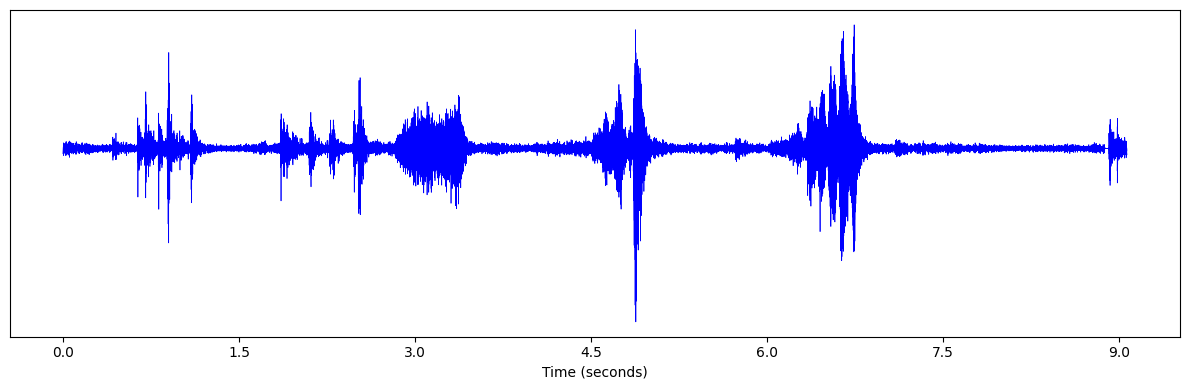

In [29]:
def create_waveform_plot(time_data, waveform_data, emotionLabels=None, emotionProbabilities=None, title=None, highlight_slice=None,figure_size=(12, 6), display=True, sliceDuration=3, sliceStart=0, simple=False):
    """Create a waveform plot and return as base64 encoded image"""
    fig, ax = plt.subplots(figsize=figure_size)
    ax.plot(time_data, waveform_data, 'b-', linewidth=0.5)
    ax.set_xlabel('Time (seconds)')
    if highlight_slice is not None:
        plt.ylabel('Amplitude')
    else:
        # Remove yticks
        ax.set_yticks([])  # Hide y-axis ticks

    printVerbose = lambda *args, **kwargs: None  # Placeholder for verbose output

    if title:
        ax.set_title(title)
    if not simple:
        ax.grid(True, alpha=0.3)
    # maxw, minw = np.max(np.abs(waveform_data)), np.min(np.abs(waveform_data))
    # maxw = max(maxw, 1e-6)
    # minw = min(minw, -1e-6)
    # maxw = max(abs(maxw), abs(minw))
    # minw = -maxw
    minw, maxw = (-1.0, 1.0)  # Fixed range for better visualization

    # ax.set_ylim(-1.1, 1.1)
    if not simple:
        ax.set_ylim(minw*1.1, maxw*1.1)

    x_min, x_max = ax.get_xlim()
    # print(f"x_min: {x_min}, x_max: {x_max}")
    trans = ax.transData.transform
    sliceBoundaries = []
    
    if emotionLabels is not None:
        assert emotionProbabilities is not None, "Emotion probabilities must be provided if emotion labels are given"
        assert len(emotionLabels) == len(emotionProbabilities), "Emotion labels and probabilities must have the same length"
        # get pixel boundaries for each emotion label
        right_bound_pixel, _ = trans((x_max, 0))
        left_bound_pixel, _ = trans((x_min, 0))
        for i, (label, probabilities) in enumerate(zip(emotionLabels, emotionProbabilities)):
            assert len(probabilities) == len(emotions.EMOTIONS), "Probabilities must match the number of emotions"
            time_left = i * 3  # 3 seconds per slice
            time_right = (i + 1) * 3
            slice_left, _ = trans((time_left, 0))
            slice_right, _ = trans((time_right, 0))

            def floatMap (x, in_min, in_max, out_min, out_max):
                """Map a float from one range to another"""
                return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

            relative_left_px = floatMap(slice_left, left_bound_pixel, right_bound_pixel, 0, 1)
            relative_right_px = floatMap(slice_right, left_bound_pixel, right_bound_pixel, 0, 1)
            sliceBoundaries.append((relative_left_px, relative_right_px))

        # Add slice boundaries and labels for full waveform
        if highlight_slice is None and len(time_data) > 0 and not simple:
            duration = time_data[-1]
            num_slices = len(emotionLabels)

            printVerbose(f"Duration: {duration}, Slice Duration: {sliceDuration}, Number of Slices: {num_slices}")
            
            for i in range(0, num_slices+1):
                slice_time = i * sliceDuration + sliceStart
                if slice_time < duration:
                    ax.axvline(x=slice_time, color='r', linestyle='--', alpha=0.6)
            
            # Add slice labels
            for i in range(num_slices):
                slice_start = i * sliceDuration
                slice_center = slice_start + sliceDuration / 2
                if slice_center < duration:
                    label = emotionLabels[i] if i < len(emotionLabels) else "Unknown"
                    printVerbose('emotionProbabilities[i]', emotionProbabilities[i])
                    textlabel = emotionLabels[i]+" %.1f%%"%(emotionProbabilities[i][emotionLabels[i]]*100) if emotionLabels else ""
                    printVerbose('emotions.EMOTIONS_TO_COLOR',emotions.EMOTIONS_TO_COLOR)
                    printVerbose('label',label)
                    printVerbose('label in emotions.EMOTIONS_TO_COLOR.keys():', label in emotions.EMOTIONS_TO_COLOR.keys())
                    facecolor = emotions.EMOTIONS_TO_COLOR[label] if label in emotions.EMOTIONS_TO_COLOR.keys() else 'lightgrey'
                    plt.text(slice_center, 0.9, textlabel, ha='center', va='center', 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor=facecolor, alpha=0.7),
                            fontsize=14, fontweight='bold')
                
    # // xticks every sliceDuration/2, starting from sliceStart
    x_ticks = np.arange(max(sliceStart, time_data[0]), time_data[-1]*1.1, sliceDuration/2.0)
    ax.set_xticks(x_ticks)
    
    plt.tight_layout()
    
    if display:
        plt.show()
    # Convert plot to base64 string
    img = io.BytesIO()
    plt.savefig(img, format='png', dpi=100, bbox_inches='tight')
    img.seek(0)
    plot_url = base64.b64encode(img.getvalue()).decode()
    plt.close()
    
    return plot_url, sliceBoundaries, (fig, ax)

duration = len(waveform_data) / HIGH_SAMPLE_RATE
time_data = np.linspace(0, duration, len(waveform_data))

plot_url, sliceBoundaries, (fig,ax) = create_waveform_plot(time_data, waveform_data, emotionLabels, emotionProbabilities, display=True, simple=True, figure_size=(12, 4))

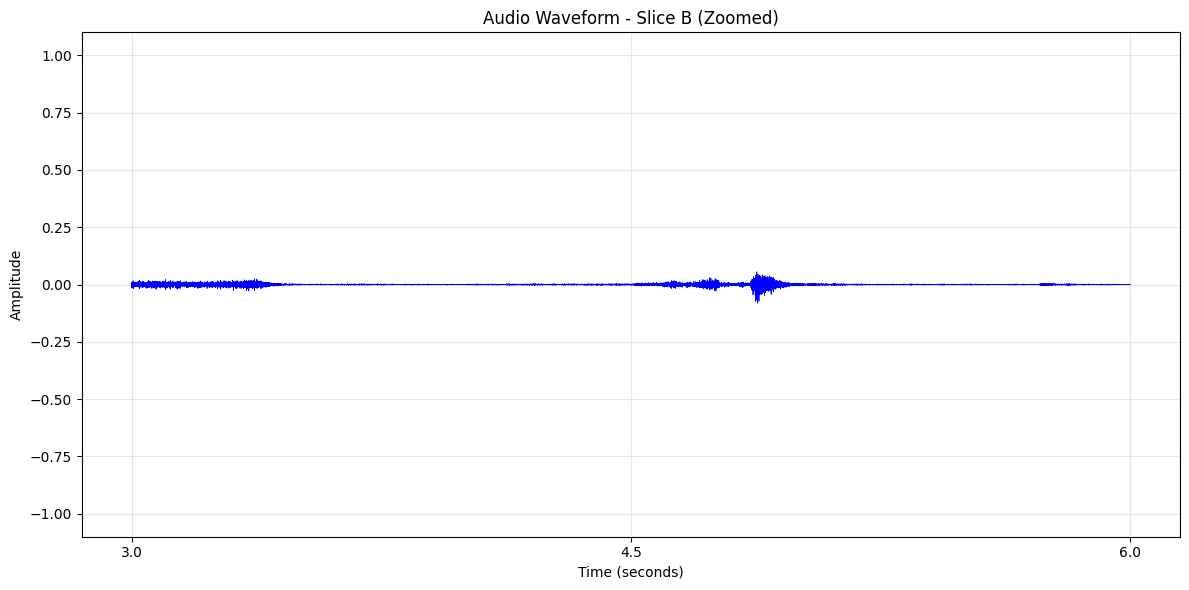

In [30]:
# Extract slice data

start_sample = 3 * HIGH_SAMPLE_RATE
end_sample = min(6 * HIGH_SAMPLE_RATE, len(time_data))

slice_time = time_data[start_sample:end_sample]
slice_waveform = waveform_data[start_sample:end_sample]


# Create zoomed plot
slice_label = chr(ord('A') + slice_id)
plot_url = create_waveform_plot(
    slice_time, 
    slice_waveform, 
    title=f"Audio Waveform - Slice {slice_label} (Zoomed)",
    highlight_slice=True
)

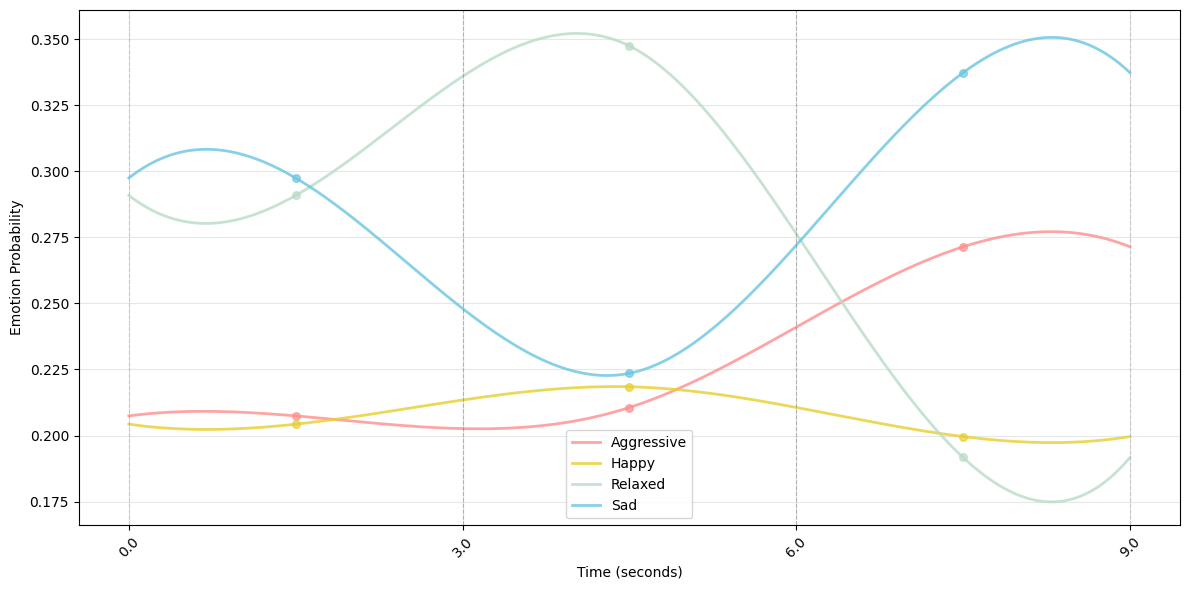

In [31]:
from scipy.interpolate import interp1d


def plot_emotion_graph(emotionProbabilities, startstop, figure_size=(12, 6), display=False, smooth=True):
    sample2Seconds = lambda x: x / CLASSIFIER_SR
    startstop_s = [(sample2Seconds(start), sample2Seconds(stop)) for start, stop in startstop]

    fig, ax = plt.subplots(figsize=figure_size)

    # points should be a dict with a key per each emotion, and the value is a list of tuples (time, probability)
    points = {}
    for d, (start, stop) in zip(emotionProbabilities, startstop_s):
        for emotion, prob in d.items():
            if emotion not in points:
                points[emotion] = []
            # Calculate the time for this segment (center of segment)
            segment_time = (start + stop) / 2
            points[emotion].append((segment_time, prob))

    # Get the overall time range
    if startstop_s:
        overall_start = min(start for start, _ in startstop_s)
        overall_end = max(stop for _, stop in startstop_s)
    else:
        overall_start, overall_end = 0, 1

    # Create lines for each emotion (smooth or simple)
    for emotion, pts in points.items():
        if len(pts) == 0:
            continue
            
        # Sort points by time
        pts = sorted(pts, key=lambda x: x[0])
        point_times, point_probs = zip(*pts)
        
        emotion_capitalized = emotion.capitalize()
        color = emotions.EMOTIONS_TO_COLOR.get(emotion, 'lightgrey')
        
        if smooth and len(pts) >= 2:
            # Smooth interpolated lines
            # Extend the line to cover the full time range
            # Add points at the beginning and end with the same probability as the first/last points
            extended_times = [overall_start] + list(point_times) + [overall_end]
            extended_probs = [point_probs[0]] + list(point_probs) + [point_probs[-1]]
            
            # Create interpolation function
            # Use 'cubic' for smooth curves, 'linear' for straight lines between points
            try:
                interp_func = interp1d(extended_times, extended_probs, kind='cubic', 
                                     bounds_error=False, fill_value='extrapolate')
            except:
                # Fall back to linear interpolation if cubic fails
                interp_func = interp1d(extended_times, extended_probs, kind='linear', 
                                     bounds_error=False, fill_value='extrapolate')
            
            # Generate smooth time series for plotting
            smooth_times = np.linspace(overall_start, overall_end, 200)
            smooth_probs = interp_func(smooth_times)
            
            # Clip probabilities to [0, 1] range
            smooth_probs = np.clip(smooth_probs, 0, 1)
            
            # Plot the smooth line
            ax.plot(smooth_times, smooth_probs, 
                   label=emotion_capitalized, 
                   color=color, 
                   linewidth=2, alpha=0.8)
            
            # Plot the original data points
            ax.scatter(point_times, point_probs, 
                      alpha=0.7, 
                      color=color,
                      s=30, zorder=5)
        else:
            # Simple lines connecting points directly
            # Add start and end points to extend the line
            start_time, start_prob = pts[0]
            end_time, end_prob = pts[-1]
            extended_times = [overall_start] + list(point_times) + [overall_end]
            extended_probs = [start_prob] + list(point_probs) + [end_prob]
            
            # Plot simple line
            ax.plot(extended_times, extended_probs, 
                   linestyle='--', 
                   label=emotion_capitalized, 
                   color=color, 
                   linewidth=1, alpha=0.8)
            
            # Plot the original data points
            ax.scatter(point_times, point_probs, 
                      alpha=0.5, 
                      color=color)

    # Set x-axis ticks

    xticks = np.arange(overall_start, overall_end + 1, 3)
    ax.set_xticks(xticks, [f"{t:.1f}" for t in xticks], rotation=45)

    # Add vertical dashed lines for each segment
    for start, end in startstop_s:
        ax.axvline(x=start, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)
        ax.axvline(x=end, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Emotion Probability')
    # ax.set_ylim(0, 1)  # Ensure y-axis covers full probability range
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()

    if display:
        plt.show()
    
    # Convert plot to base64 string
    img = io.BytesIO()
    plt.savefig(img, format='png', dpi=100, bbox_inches='tight')
    img.seek(0)
    plot_url = base64.b64encode(img.getvalue()).decode()
    plt.close()

    return plot_url

emotionGraphUrl = plot_emotion_graph(emotionProbabilities, startstop, display=True)